In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
import re
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
from datetime import datetime
import time
import toolz
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from toolz import groupby, count, reduce, reduceby, countby, identity
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
from scipy import stats
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import plotly.io as pio
from dash import Dash, html, dcc
import plotly.graph_objects as go
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmvae16 as M16
import gmmvaeBeta00 as Mb0
import gmmTraining as Train

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [2]:
from sklearn.decomposition import PCA

In [3]:
sc.settings.set_figure_params(
    dpi=200,
    facecolor="white",
)
#pio.renderers.default = "png"
sns.set_palette(sns.color_palette("pastel"),)
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['savefig.dpi'] = 200
print(torch.cuda.is_available())

True


In [4]:
adataz = sc.read_h5ad("./data/scgen/scGen_datasets/train_zheng.h5ad",)
adatakt = sc.read_h5ad("data/scgen/scGen_datasets/train_study.h5ad",)
adatakv = sc.read_h5ad("data/scgen/scGen_datasets/valid_study.h5ad",)
adataz.X = adataz.X.toarray()
adatakt.X = adatakt.X.toarray()
adatakv.X = adatakv.X.toarray()

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/mambafor

In [5]:
sc.pp.pca(adataz,)
sc.pp.neighbors(adataz,)
sc.tl.umap(adataz,)
sc.tl.louvain(adataz,)
sc.pp.pca(adatakt,)
sc.pp.neighbors(adatakt,)
sc.tl.umap(adatakt,)
sc.tl.louvain(adatakt,)
sc.pp.pca(adatakv,)
sc.pp.neighbors(adatakv,)
sc.tl.umap(adatakv,)
sc.tl.louvain(adatakv,)

In [6]:
enc_labels = LabelEncoder()
enc_conds = LabelEncoder()

labelskt = enc_labels.fit_transform(adatakt.obs["cell_type"],)
labelskt = F.one_hot(torch.tensor(labelskt)).float()
datakt = torch.tensor(adatakt.X)
datakt.shape
adatakt.obs["label"] = enc_labels.inverse_transform(
    labelskt.argmax(-1).detach().numpy(),
)
adatakt.obs["label_num"] = labelskt.argmax(-1).detach().numpy().astype('str')
louvainkt = [int(x) for x in adatakt.obs["louvain"]]
louvainkt = F.one_hot(torch.tensor(louvainkt)).float()
conditionskt = enc_conds.fit_transform(adatakt.obs["condition"],)
conditionskt = F.one_hot(torch.tensor(conditionskt)).float()


labelskv = enc_labels.fit_transform(adatakv.obs["cell_type"],)
labelskv = F.one_hot(torch.tensor(labelskv)).float()
datakv = torch.tensor(adatakv.X)
datakv.shape
adatakv.obs["label"] = enc_labels.inverse_transform(
    labelskv.argmax(-1).detach().numpy(),
)
adatakv.obs["label_num"] = labelskv.argmax(-1).detach().numpy().astype('str')
louvainkv = [int(x) for x in adatakv.obs["louvain"]]
louvainkv = F.one_hot(torch.tensor(louvainkv)).float()
conditionskv = enc_conds.fit_transform(adatakv.obs["condition"],)
conditionskv = F.one_hot(torch.tensor(conditionskv)).float()

labelsz = enc_labels.fit_transform(adataz.obs["cell_type"],)
labelsz = F.one_hot(torch.tensor(labelsz)).float()
dataz = torch.tensor(adataz.X)
dataz.shape
adataz.obs["label"] = enc_labels.inverse_transform(
    labelsz.argmax(-1).detach().numpy(),
)
adataz.obs["label_num"] = labelsz.argmax(-1).detach().numpy().astype('str')
louvainz = [int(x) for x in adataz.obs["louvain"]]
louvainz = F.one_hot(torch.tensor(louvainz)).float()
#conditionsz = enc_conds.fit_transform(adataz.obs["condition"],)
#conditionsz = F.one_hot(torch.tensor(conditionsz), nu).float()
#F.one_hot?
conditionsz = enc_conds.fit_transform(adataz.obs["condition"],)
conditionsz = F.one_hot(torch.tensor(conditionsz), num_classes=2,).float()

In [7]:
labeledSubset = ut.randomSubset(s=len(adatakt), r=0.45)
labeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [datakt[labeledSubset],
                labelskt[labeledSubset],
                conditionskt[labeledSubset],
                ],),
            batch_size=2**11,
            shuffle=True,
            )
unlabeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [datakt[~labeledSubset],
                labelskt[~labeledSubset],
                conditionskt[~labeledSubset],
                ],),
            batch_size=2**11,
            shuffle=True,
            )
test_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [datakv,
                labelskv,
                conditionskv,
                ],),
            batch_size=2**11,
            shuffle=True,
            )
train_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [datakt,
                labelskt,
                conditionskt,
                ],),
            batch_size=2**11,
            shuffle=True,
            )
z_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [dataz,
                labelsz,
                conditionsz,
                ],),
            batch_size=2**11,
            shuffle=True,
            )

In [17]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602zC2(
    nx=adatakt.n_vars,
    nz=24,
    nw=24,
    nclasses=labelskt.shape[1],
    nc1=conditionskt.shape[1],
    #concentration=0.5e-1,
    concentration=1e0,
    dropout=15e-2,
    bn=True,
    reclosstype="mse",
    #reclosstype="Gauss",
    restrict_w=True,
    restrict_z=True,
    positive_rec=True,
    #jnh=2**12,
    #jnhp=2**12,
    #jnhq=2**12,
    numhidden=4,
    numhiddenp=4,
    numhiddenq=4,
    #learned_prior=True,
    learned_prior=False,
)
model.apply(init_weights)
print()

In [21]:
#model.load_state_dict(
#    torch.load("results/Kang_ss_cond_prior_model21671022818.509579model_state.pt",))
model.load_state_dict(
    torch.load("results/Kang_ss_cond_prior_model21671027740.902218model_state.pt",))

<All keys matched successfully>

In [22]:
model.cpu()
model.eval()
r,p,s = ut.estimateClusterImpurity(model, datakt, labelskt, "cpu", conditionskt, )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("kt_acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())
r,p,s = ut.estimateClusterImpurity(model, datakv, labelskv, "cpu", conditionskv, )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("kv_acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())

[0. 1. 2. 3. 4. 5. 6.] [0.996875   0.97899344 0.99835998 0.99390244 0.97885835 0.97793886
 0.99513145] [1600. 2285. 4878.  984.  946. 3173. 1027.]
kt_acc= 
 0.9891224064996978 0.9885799312822413
[0. 1. 2. 3. 4. 5. 6.] [0.94418605 0.84375    0.93286713 0.81081081 0.81372549 0.85426009
 0.90243902] [215. 288. 715. 111. 102. 446. 123.]
kv_acc= 
 0.889 0.8717197992088561


In [23]:
model.eval()
r,p,s = ut.estimateClusterImpurityLoop(model, dataz, labelsz, "cuda", conditionsz )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("z_acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())

[0. 1. 2. 3. 1. 5. 6.] [0.97982709 0.98574822 0.96508505 0.80677966 0.5        0.81111111
 0.78534031] [ 347.  421. 1117.  295.   72.  180.  191.]
z_acc= 
 0.9161265726267632 0.8334130633382443


In [35]:
adataz.obs
conditionsz
adatakt.obs
conditionskt

combined_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                torch.cat([datakt,dataz], dim=0),
                torch.cat([labelskt, labelsz], dim=0),
                torch.cat([conditionskt, conditionsz], dim=0),
                ],),
            batch_size=2**11,
            shuffle=True,
            )

In [34]:
dataz.shape
a = torch.ones(3,2)
b = torch.zeros(3,2)
torch.cat([a,b], dim=0)
datakt.shape
torch.cat([dataz, datakt], dim=0).shape

torch.Size([14893, 7000])

In [36]:
# combined dataset training
Train.trainSemiSuperLoopCond(
    model,
    combined_loader,
    combined_loader,
    combined_loader,
    num_epochs=10,
    lrs = [
        1e-5,
        1e-4,
        1e-3,
        1e-3,
        1e-4,
        1e-5,
        1e-6,
    ],
    test_accuracy=False,
    report_interval=0,
    wt=1e-5,
    #do_unlabeled=True,
    do_unlabeled=False,
    do_validation=False,
)

epoch's lr =  1e-05
epoch's lr =  0.0001
epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.0001
epoch's lr =  1e-05
epoch's lr =  1e-06
done training


In [37]:
model.eval()
r,p,s = ut.estimateClusterImpurityLoop(model, dataz, labelsz, "cuda", conditionsz )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("z_acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())

[0. 1. 2. 3. 4. 5. 6.] [0.99127907 0.99377593 0.99386503 0.98397436 0.89473684 1.
 0.97468354] [ 344.  482. 1141.  312.   38.  148.  158.]
z_acc= 
 0.9900876858558902 0.9760449684908095


In [38]:
model.cpu()
model.eval()
r,p,s = ut.estimateClusterImpurity(model, datakt, labelskt, "cpu", conditionskt, )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("kt_acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())
r,p,s = ut.estimateClusterImpurity(model, datakv, labelskv, "cpu", conditionskv, )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("kv_acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())

[0. 1. 2. 3. 4. 5. 6.] [0.9937578  0.978223   0.99815309 0.9969419  0.98290598 0.97953401
 0.99514091] [1602. 2296. 4873.  981.  936. 3176. 1029.]
kt_acc= 
 0.9893909890552609 0.9892366693121828
[0. 1. 2. 3. 4. 5. 6.] [0.94063927 0.82       0.93239437 0.80733945 0.85714286 0.85454545
 0.91935484] [219. 300. 710. 109.  98. 440. 124.]
kv_acc= 
 0.888 0.8759166050775499


In [40]:
adata = sc.read_h5ad("./data/scgen/scGen_datasets/train_zheng.h5ad",)
adata.X = adata.X.toarray()
adata.obs[["label", "label_num"]] = adataz.obs[["label", "label_num"]]
ctrlMarker =  adata.obs["condition"].to_numpy() == "control" 

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [45]:
ctrlMarker.sum()
adata.obs
bdata = adata.copy()
bdata.obs["condition"] = ["simulated"] * bdata.n_obs
bdata.obs

,cell_type,condition,mt_frac,n_counts,n_genes,percent_mito,study,label,label_num
index,,,,,,,,,
AAACATACAACCAC-1-1,CD4 T cells,simulated,NaN,2341.0,781,0.030178,Zheng et al,CD4 T cells,2
AAACATTGAGCTAC-1-1,B cells,simulated,NaN,4710.0,1352,0.037936,Zheng et al,B cells,0
AAACATTGATCAGC-1-1,CD4 T cells,simulated,NaN,3116.0,1131,0.008897,Zheng et al,CD4 T cells,2
AAACCGTGCTTCCG-1-1,CD14+ Monocytes,simulated,NaN,2588.0,960,0.017431,Zheng et al,CD14+ Monocytes,1
AAACCGTGTATGCG-1-1,NK cells,simulated,NaN,966.0,522,0.012245,Zheng et al,NK cells,6
...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1-1,CD14+ Monocytes,simulated,NaN,3381.0,1155,0.021104,Zheng et al,CD14+ Monocytes,1
TTTCTACTGAGGCA-1-1,B cells,simulated,NaN,3407.0,1227,0.009294,Zheng et al,B cells,0
TTTCTACTTCCTCG-1-1,B cells,simulated,NaN,1642.0,622,0.021971,Zheng et al,B cells,0


In [48]:
# stimulation simulation on Z-data
model.eval()
out0 = model(input=dataz,
                         y=labelsz,
                         cond1=conditionsz,
                        )
mu_zs = out0["mu_z"].detach()
zs = out0["z"].detach()
mu_ws = out0["mu_w"].detach()
ws = out0["w"].detach()

In [49]:
cs = 1-conditionsz
ys=labelsz

In [50]:
xs = model.Px(
    torch.cat([mu_zs, cs], dim=-1),)

In [66]:
zss = model.Pz(
    torch.cat([mu_ws, cs], dim=-1),)
ys=labelsz
zss = ys.unsqueeze(-1) * zss
zss = zss.sum(1)
zss = zss[:,:model.nz]
xss = model.Px(
    torch.cat([zss, cs], dim=-1),)

In [67]:
r,p,s = ut.estimateClusterImpurity(model, xs, labelsz, "cpu", 1-conditionsz)
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("kv_acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())
r,p,s = ut.estimateClusterImpurity(model, xss, labelsz, "cpu", 1-conditionsz)
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print("kv_acc= \n", (r*s).sum().item() / s.sum().item(), r.mean().item())

[0. 1. 2. 3. 4. 5. 6.] [0.99418605 0.99377593 0.96040438 0.99233716 1.         0.98684211
 0.93333333] [ 344.  482. 1187.  261.   32.  152.  165.]
kv_acc= 
 0.9744567289363324 0.9801255663229925
[0. 1. 2. 3. 4. 5. 6.] [1. 1. 1. 1. 1. 1. 1.] [ 342.  480. 1144.  316.   37.  150.  154.]
kv_acc= 
 1.0 1.0


In [53]:
xs.shape
# only did x->z->xs skipping passing through w for all the hassle since model scrumbles condition on z decently well

torch.Size([2623, 7000])

In [77]:
bdata.X = xs.detach().numpy()
#bdata.X = xss.detach().numpy()

In [78]:
xdata = ad.concat([adata, bdata], label="set", join="inner",)
xdata.var_names_make_unique()
xdata.obs_names_make_unique()

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [79]:
xdata.obs
sc.pp.pca(xdata,)
sc.pp.neighbors(xdata,)
sc.tl.umap(xdata,)

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


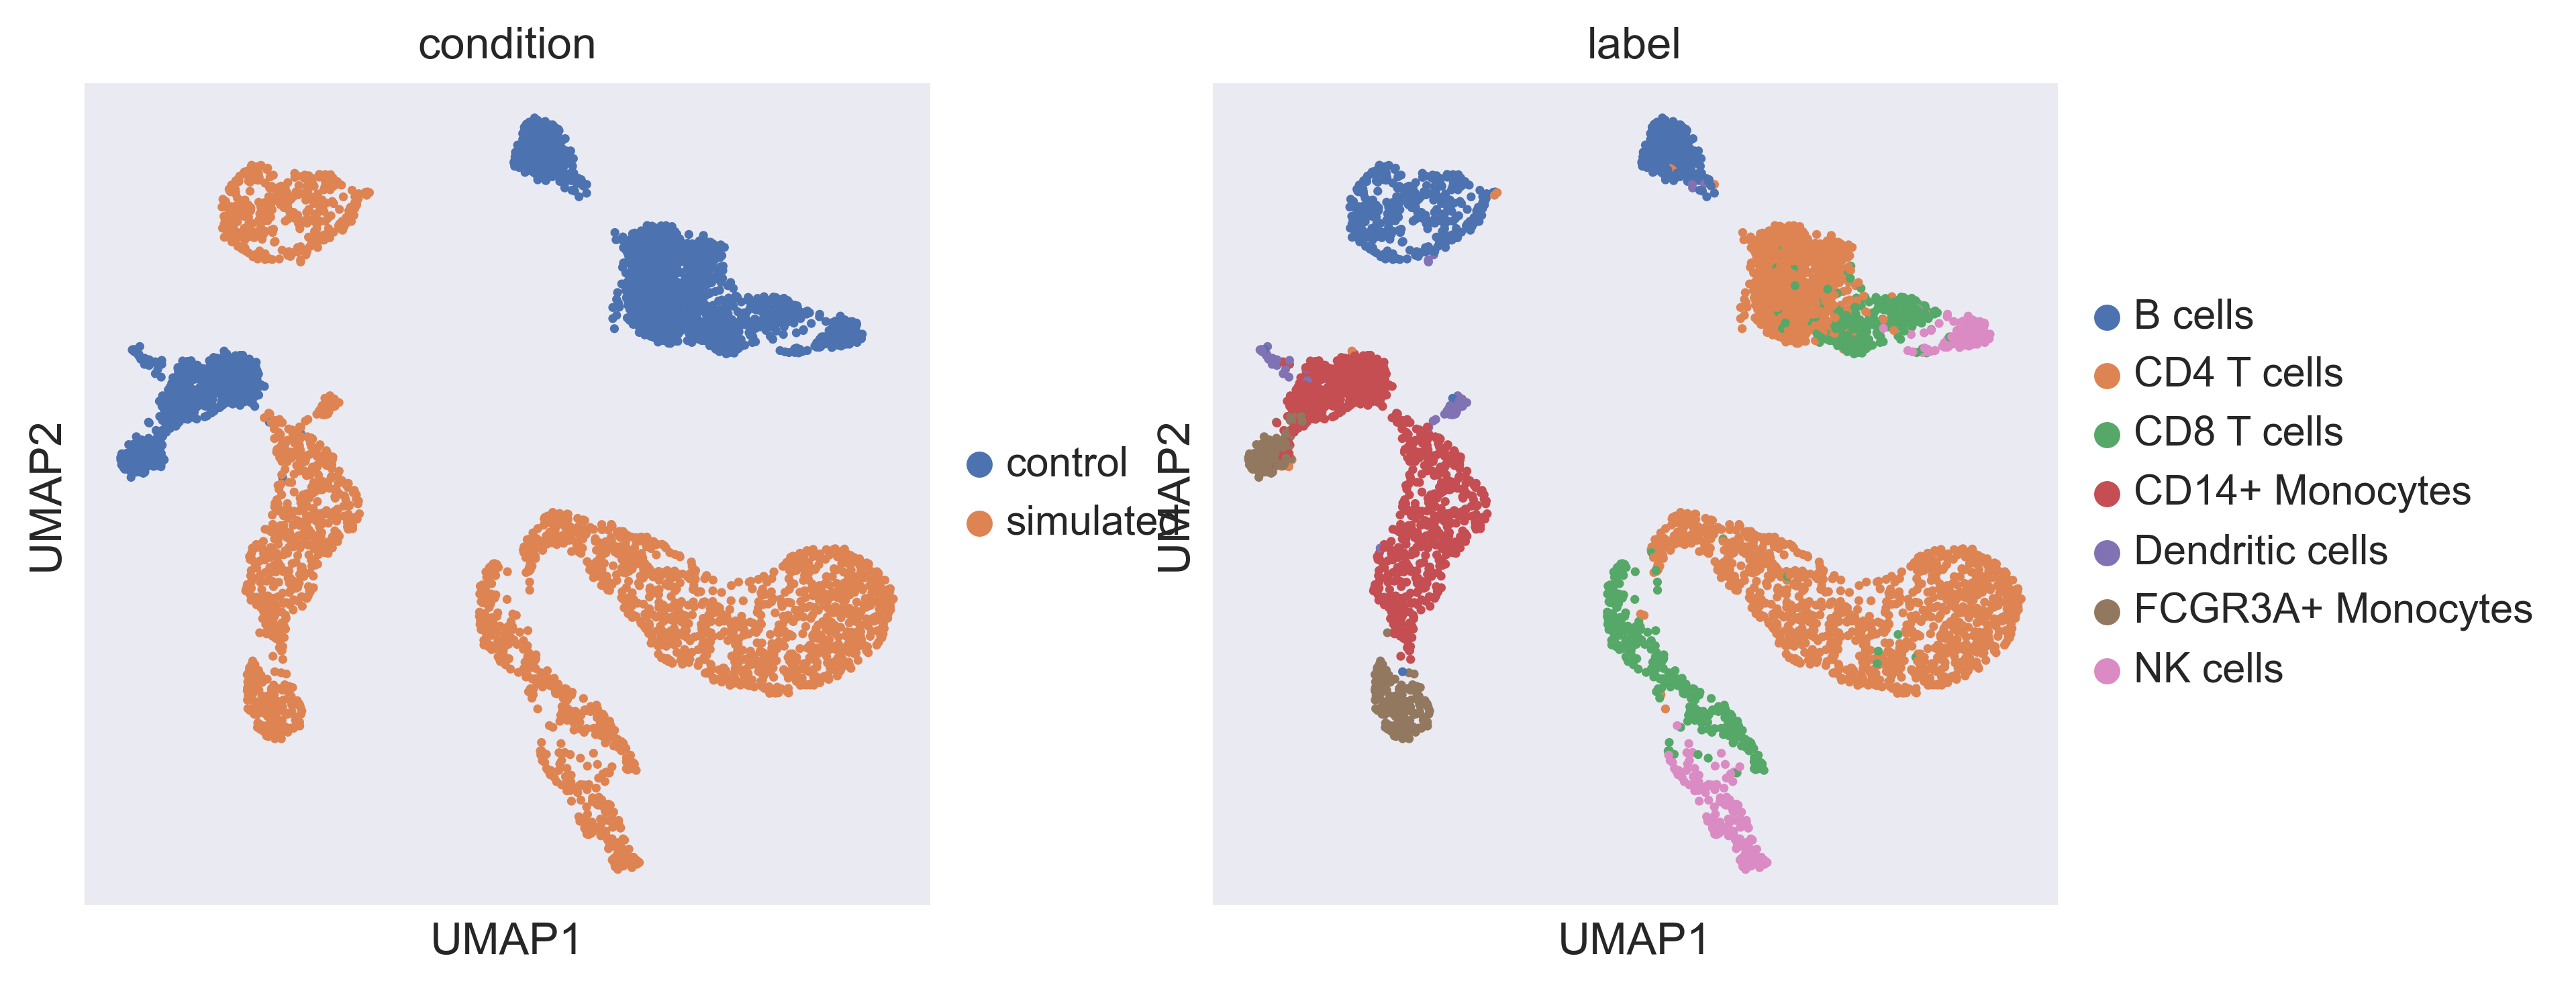

In [80]:
sc.pl.umap(xdata,
           color=["condition",
                  "label", ],
           ncols=2,
          )

In [81]:
datakt.shape
xdata

AnnData object with n_obs × n_vars = 5246 × 7000
    obs: 'cell_type', 'condition', 'mt_frac', 'n_counts', 'n_genes', 'percent_mito', 'study', 'label', 'label_num', 'set'
    uns: 'pca', 'neighbors', 'umap', 'condition_colors', 'label_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [82]:
model.eval()
output = model(
    input=torch.cat([dataz,xs], dim=0),
    y=torch.cat([labelsz, labelsz], dim=0),
    cond1=torch.cat([conditionsz, 1-conditionsz], dim=0),
)
#mu_zs = output["mu_z"].detach()
#zs = output["z"].detach()
#mu_ws = output["mu_w"].detach()
#ws = output["w"].detach()
xdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
xdata.obsm["z"] = output["z"].detach().numpy()
xdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
xdata.obsm["w"] = output["w"].detach().numpy()
xdata.obs["predict"] = output["q_y"].argmax(-1).detach().numpy().astype(str)
del output

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


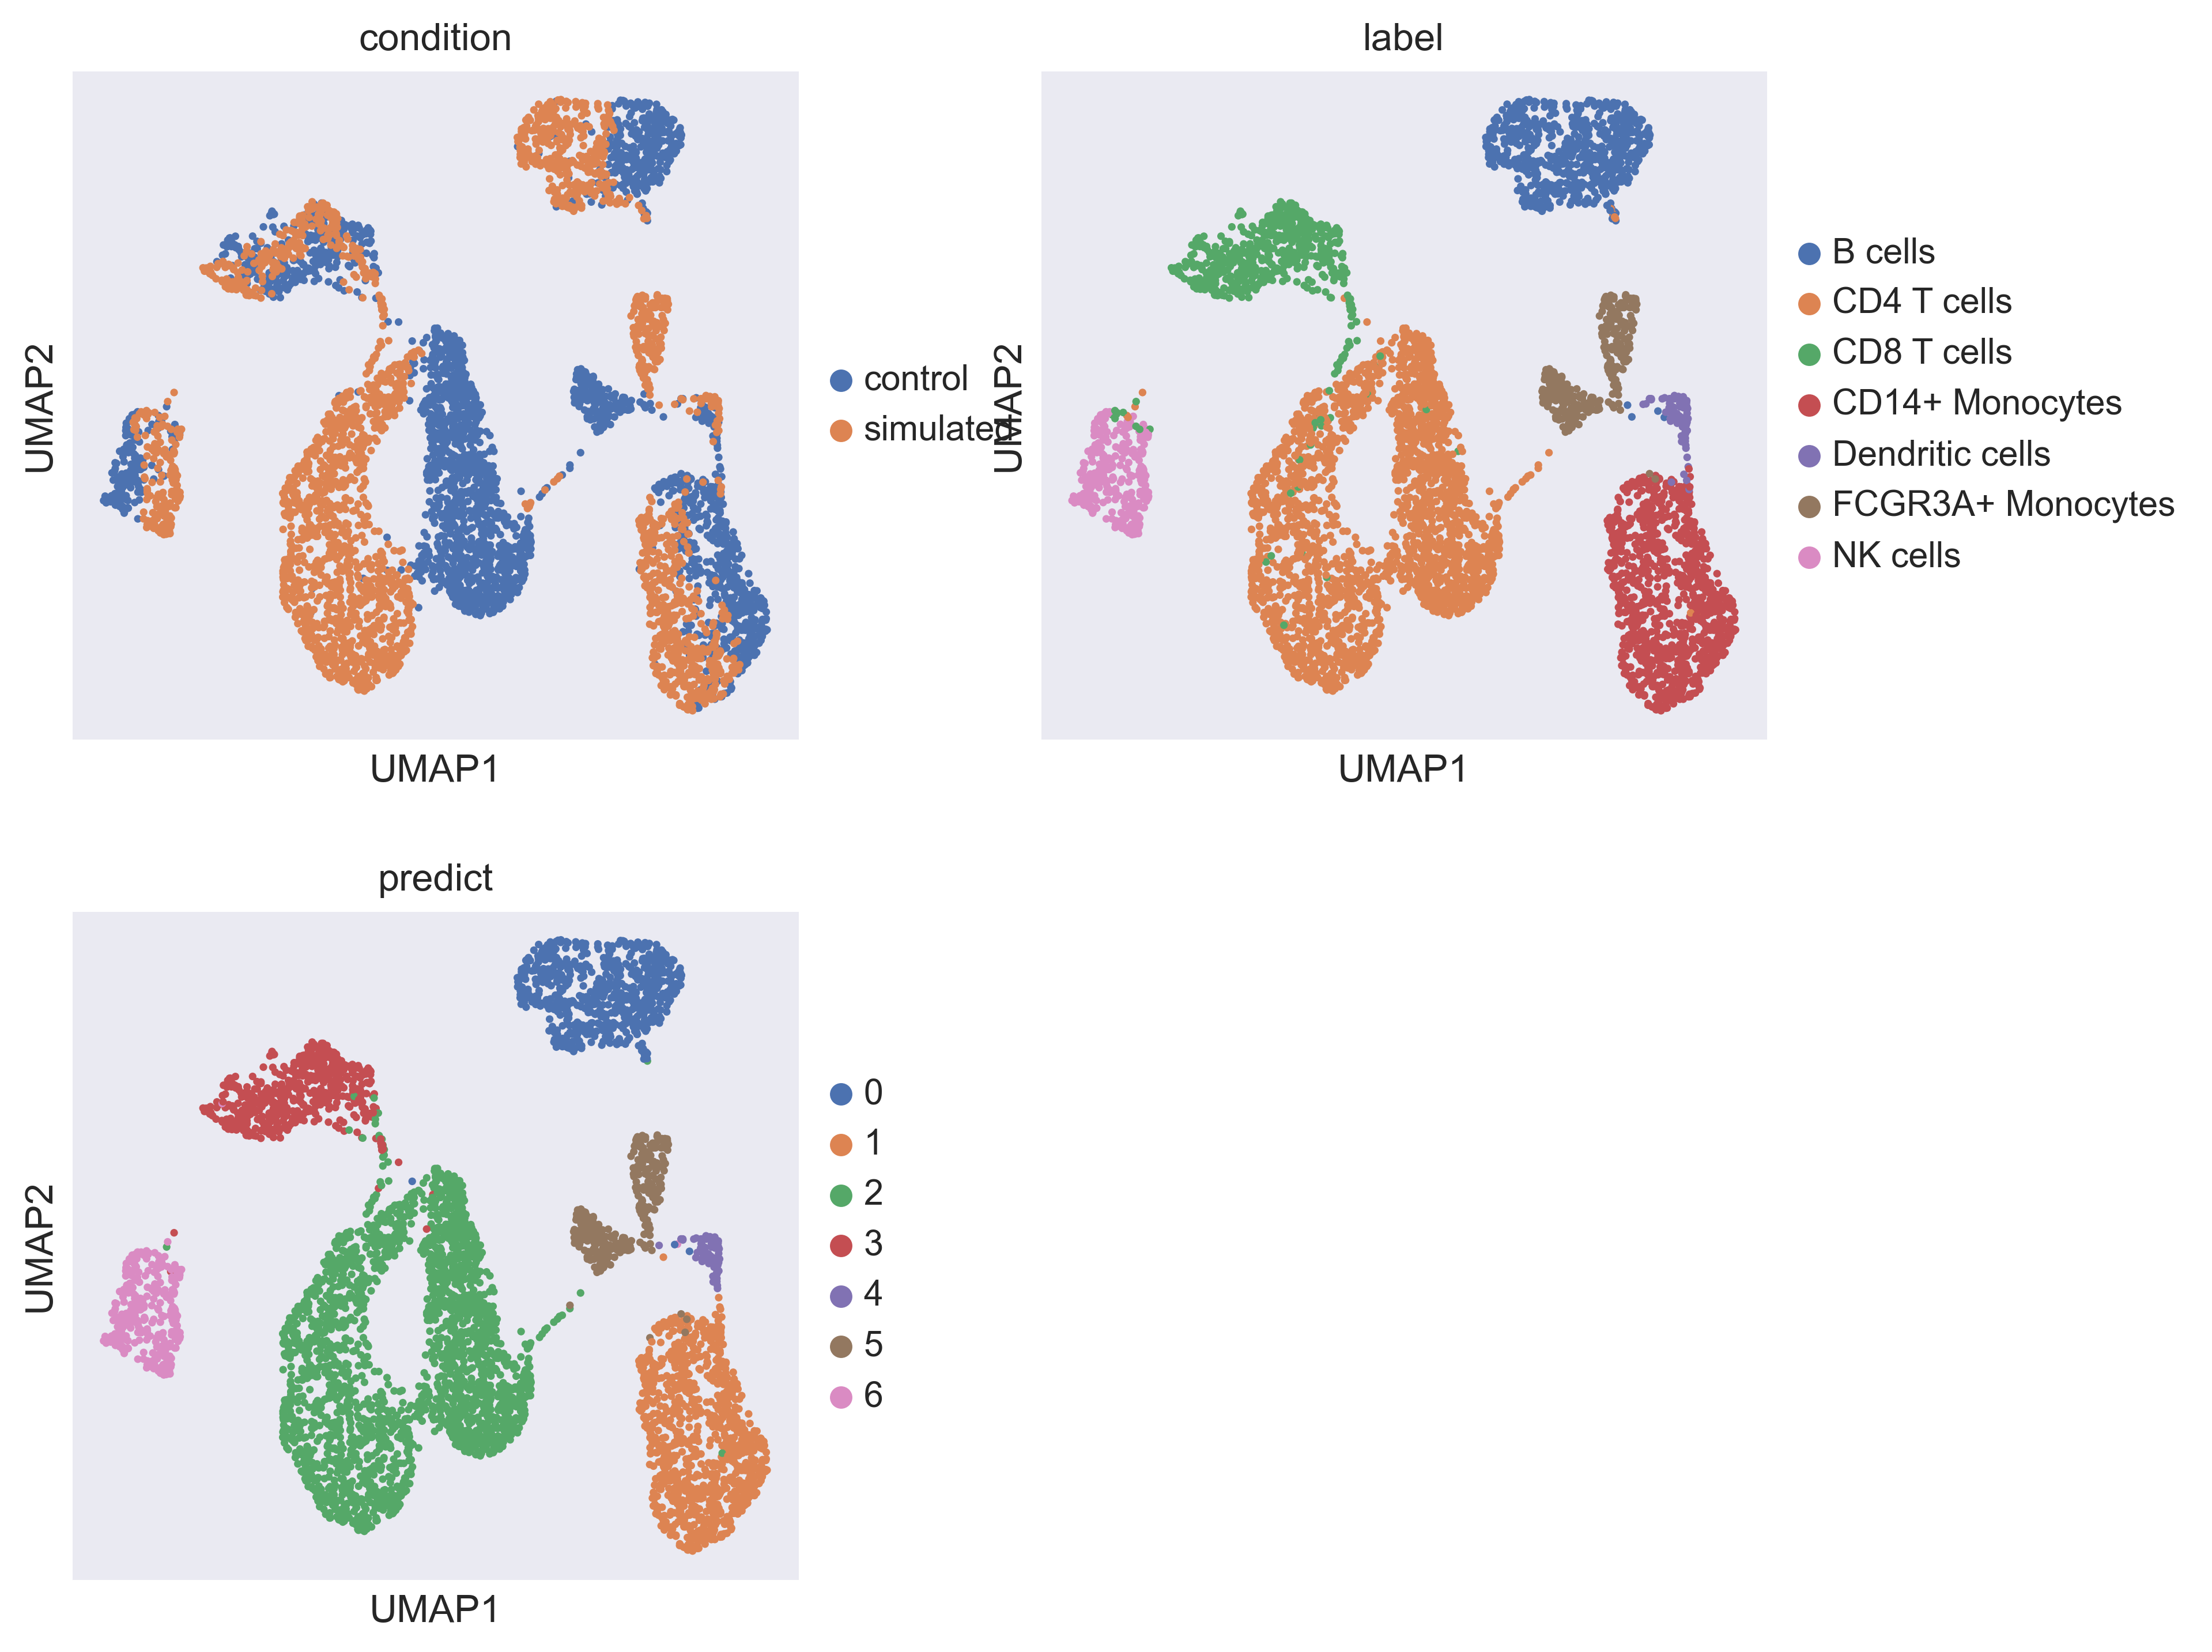

In [83]:
xdata.obs
sc.pp.neighbors(xdata, use_rep="mu_z",)
sc.tl.umap(xdata,)
sc.pl.umap(xdata,
           color=["condition",
                  "label",
                  "predict",
                 ],
           ncols=2,
          )